<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/09__SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Get Data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.22 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check files within PubMed_20k_RCT dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all filenames in the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [6]:
# Create function to read the lines in document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read in training lines
train_lines = get_lines(data_dir+"train.txt") # read lines within training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

```
[{'line_number': 0,
    'target': "BACKGROUND",
    'text': "Emotional eating is associated with overeating and the development of obesity .\n",
    "total_lines": 11},
    { ... }]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an emply list of abstracts (list of dicts in future)

  # Loop through each line
  for line in input_lines:
    if line.startswith("###"): # check if it's ID line
      abstract_id = line
      abstract_lines = "" # reset the sentence string if it's ID line
    elif line.isspace(): # check if line is '\n'
      abstract_line_split = abstract_lines.splitlines() # split sentences string into sentences list

      # Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict for line
        target_text_split = abstract_line.split("\t") # split target labels from text

        line_data["target"] = target_text_split[0] # set target label
        line_data["text"] = target_text_split[1].lower() # set target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1 # (just need to start from 0)

        abstract_samples.append(line_data) # add data to list

    else: # if not first or second, then this is line - need to concatenate to empty string
      abstract_lines += line

  return abstract_samples

In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev = validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 822 ms, sys: 189 ms, total: 1.01 s
Wall time: 2.45 s


(180040, 30212, 30135)

In [11]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

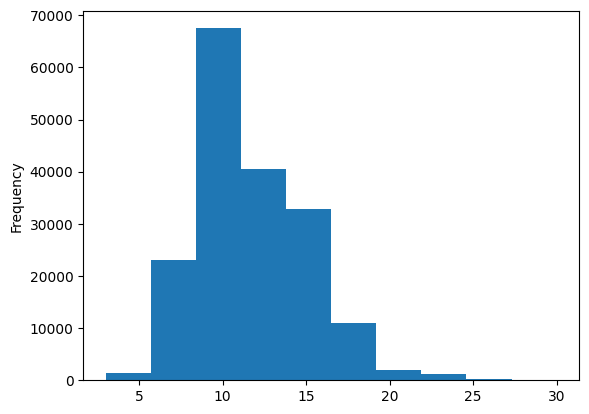

In [15]:
# Length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [16]:
# Convert abstract lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [18]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoded labels

In [19]:
# Extract labels and encode into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Series of modelling experiments

## Model 0: Baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [22]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper_function.py

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-14 15:15:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-14 15:15:04 (59.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import calculate_results

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [31]:
# how long each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_leng = np.mean(sent_lens)
avg_sent_leng

26.338269273494777

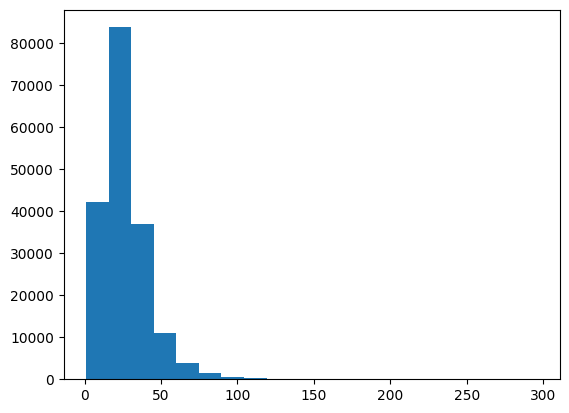

In [32]:
# What's the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [33]:
# what sentence lengths covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [34]:
# max sentence length in train set
max(sent_lens)

296

### Create text_vectorizer layer

In [35]:
# max words in vocab
max_tokens = 68000

In [36]:
# Create text vectorizer
from tensorflow.keras import layers

text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                           output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [37]:
# Adapt text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# test text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
norwegian older adults pa levels differed by age .

Length of text: 9

Vectorized text:
[[10644   350   266  1067    93  1659    22   103     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# Get config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create embedding layer

In [41]:
rct_20k_text_vocab

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

In [42]:
# Create token embed layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [43]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
norwegian older adults pa levels differed by age .

Sentence after vectorization (before embedding):
[[10644   350   266  1067    93  1659    22   103     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04698708 -0.03364624 -0.0101989  ... -0.02055572  0.01746101
    0.04672084]
  [ 0.04950854  0.03766472  0.02533418 ...  0.01273355 -0.03807532
    0.02684826]
  [-0.02524997 -0.0393644  -0.01536547 ... -0.03831265  0.03493252
   -0.01761901]
  ...
  [ 0.02667947  0.02662988  0.0145348  ... -0.0103872  -0.01852117
    0.00962458]
  [ 0.02667947  0.02662988  0.0145348  ... -0.0103872  -0.01852117
    0.00962458]
  [ 0.02667947  0.02662988  0.0145348  ... -0.0103872  -0.01852117
    0.00962

# Create datasets

In [44]:
# Trun data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
# Turn datasets into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [46]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation="relu",
                  padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [48]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
from helper_functions import create_tensorboard_callback

In [50]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step - accuracy: 0.5186 - loss: 1.1700 - val_accuracy: 0.7360 - val_loss: 0.6895
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7434 - loss: 0.6877 - val_accuracy: 0.7680 - val_loss: 0.6426
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7684 - loss: 0.6250 - val_accuracy: 0.7846 - val_loss: 0.6030


In [51]:
# Evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7842 - loss: 0.6012


[0.6032869815826416, 0.7847543954849243]

In [52]:
# Make preds
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


(array([[4.4936860e-01, 1.5771523e-01, 5.6130361e-02, 3.1140080e-01,
         2.5384968e-02],
        [3.7587380e-01, 3.7463546e-01, 9.0364413e-03, 2.3250417e-01,
         7.9501178e-03],
        [1.4962068e-01, 8.6505394e-03, 2.5257592e-03, 8.3918303e-01,
         2.0050509e-05],
        ...,
        [8.5350093e-06, 8.9799386e-04, 9.1241312e-04, 5.5860587e-06,
         9.9817550e-01],
        [4.5939915e-02, 4.2806062e-01, 9.8459974e-02, 5.4764118e-02,
         3.7277541e-01],
        [1.6402899e-01, 6.7624962e-01, 4.1243013e-02, 5.1870581e-02,
         6.6607855e-02]], dtype=float32),
 (30212, 5))

In [53]:
# Convert probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [54]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [55]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.47544022242818,
 'precision': 0.7820099988400268,
 'recall': 0.7847544022242817,
 'f1': 0.7822426653884007}

In [56]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction model

In [57]:
# Download pretrained model
import tensorflow_hub as hub
import tensorflow as tf

tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentece_encoder")

In [58]:
# test pretrained layer
random_train_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
acupressure can be applied at the acupoints of shenmen , sympathesis , kidney , liver , heart , and subcortex to improve physical pain and mental health of qol for hypertensive patients .

Sentence after embedding:
[-0.02702528 -0.05405362  0.03843188  0.04458179  0.02672908 -0.07422085
  0.02249951 -0.00123226  0.00446374 -0.0451903   0.09264662  0.04119988
 -0.03359425  0.06261935  0.04579024 -0.01595557 -0.09279322 -0.05594763
 -0.07944479  0.04115674  0.05366413  0.05382944  0.06640437 -0.03365796
  0.04876441 -0.01690269 -0.03629286  0.02263468 -0.02844365  0.00909172] (truncated output)...

Length of sentence embedding:
512


In [70]:
# Create model_2

# Define the custom layer for the Universal Sentence Encoder
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer

    def call(self, inputs):
        return self.encoder(inputs)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

# Build model
# (don't know why, but if Input((1,), ...) then it will throw an error)
inputs = tf.keras.layers.Input((), dtype=tf.string)
x = use_layer(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="tf_hub_use_model")

In [71]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
model_2.summary()

Model: "tf_hub_use_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ universal_sentence_encoder_layer_2   │ (None, 512)                 │               0 │
│ (UniversalSentenceEncoderLayer)      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5708 - loss: 1.0889 - val_accuracy: 0.6908 - val_loss: 0.7972
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7022 - loss: 0.7715 - val_accuracy: 0.7035 - val_loss: 0.7548
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7152 - loss: 0.7544 - val_accuracy: 0.7111 - val_loss: 0.7382


In [75]:
# Evaluate on all data
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7133 - loss: 0.7389


[0.7402992844581604, 0.7140209078788757]

In [76]:
# Make prediction probabilities
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step


array([[4.0117830e-01, 3.8837659e-01, 1.8782211e-03, 2.0023510e-01,
        8.3319051e-03],
       [3.3716398e-01, 5.2337033e-01, 3.0682466e-03, 1.3384458e-01,
        2.5529687e-03],
       [2.1364228e-01, 1.4136073e-01, 1.5526663e-02, 5.9150726e-01,
        3.7963130e-02],
       ...,
       [1.7182328e-03, 6.6748313e-03, 5.2866921e-02, 7.8434055e-04,
        9.3795562e-01],
       [3.9147465e-03, 5.0176233e-02, 2.0421958e-01, 1.4347467e-03,
        7.4025464e-01],
       [1.6490078e-01, 2.3565158e-01, 5.3226572e-01, 6.4133303e-03,
        6.0768656e-02]], dtype=float32)

In [77]:
# Convert to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [78]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 71.4020918840196,
 'precision': 0.7140770749897224,
 'recall': 0.7140209188401959,
 'f1': 0.7107848736790772}

In [79]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

In [80]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [84]:
# Make a function to split sentences into chracters
def split_chars(text):
  return " ".join(list(text))

# split into chars
split_chars(random_train_sentence)

'a c u p r e s s u r e   c a n   b e   a p p l i e d   a t   t h e   a c u p o i n t s   o f   s h e n m e n   ,   s y m p a t h e s i s   ,   k i d n e y   ,   l i v e r   ,   h e a r t   ,   a n d   s u b c o r t e x   t o   i m p r o v e   p h y s i c a l   p a i n   a n d   m e n t a l   h e a l t h   o f   q o l   f o r   h y p e r t e n s i v e   p a t i e n t s   .'

In [82]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [88]:
# split datasets
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [90]:
# Average char length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_lens)
mean_char_length

149.3662574983337

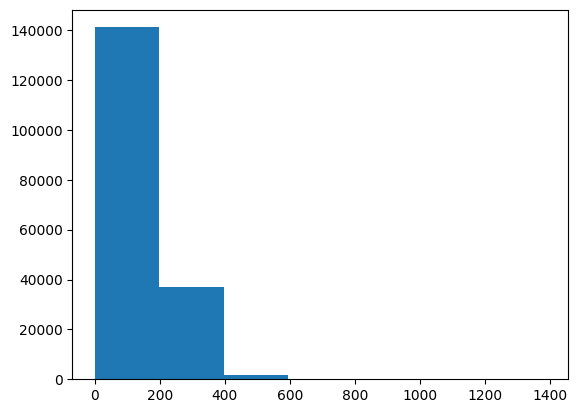

In [91]:
# Check distribution of char sequences
plt.hist(char_lens, bins=7);

In [92]:
# What char length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [93]:
# Get all keyboard chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [94]:
# Create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add space and OOV token ("[UNK]")
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                           output_sequence_length=output_seq_char_len,
                                           name="char_vectorizer")

In [95]:
# Adapt char_vectorizer
char_vectorizer.adapt(train_chars)

In [96]:
# Check char_vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [97]:
# Test vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t e n o f o v i r   r e s i s t a n c e   w a s   n o t   o b s e r v e d   .

Length of chars: 34

Vectorized chars:
[[ 3  2  6  7 17  7 21  4  8  8  2  9  4  9  3  5  6 11  2 20  5  9  6  7
   3  7 22  9  2  8 21  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Create a character-level embedding

In [100]:
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [101]:
# Create embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True, # if, for example, many 0 then just copy initial weights for all of them (for faster computations)
                              name="char_embed")

In [102]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t e n o f o v i r   r e s i s t a n c e   w a s   n o t   o b s e r v e d   .

Embedded chars (after vectorization and embedding):
[[[ 0.02401252  0.00028328 -0.03769009 ... -0.03377973 -0.01138716
    0.01679266]
  [ 0.00163487 -0.01652499 -0.01397674 ... -0.0482842   0.00323407
    0.04236699]
  [-0.04250341 -0.04378901  0.00638891 ...  0.02997837 -0.03970879
   -0.03155308]
  ...
  [ 0.0410499  -0.03128012 -0.04745508 ... -0.03683207 -0.01541623
    0.02043977]
  [ 0.0410499  -0.03128012 -0.04745508 ... -0.03683207 -0.01541623
    0.02043977]
  [ 0.0410499  -0.03128012 -0.04745508 ... -0.03683207 -0.01541623
    0.02043977]]]

Character embedding shape: (1, 290, 25)


### Build Conv1D model with char-level vectorization and embedding

In [113]:
# Build model
inputs = layers.Input(shape=(), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, 5, activation="relu",
                  padding="same")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs,
                         name="conv1d_char_embeddings")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [114]:
# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [109]:
model_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [117]:
# Fit the model chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.4478 - loss: 1.3330 - val_accuracy: 0.5582 - val_loss: 1.1071
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5598 - loss: 1.0991 - val_accuracy: 0.5934 - val_loss: 1.0091
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.5991 - loss: 1.0102 - val_accuracy: 0.6287 - val_loss: 0.9572


In [118]:
# Make preds probs
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

  1/945 ━━━━━━━━━━━━━━━━━━━━ 4:41 298ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


array([[0.13045858, 0.23768643, 0.17559941, 0.3610873 , 0.09516827],
       [0.2549034 , 0.17120172, 0.04482246, 0.46296048, 0.06611194],
       [0.16135287, 0.22430266, 0.0612248 , 0.49602827, 0.05709133],
       ...,
       [0.01946155, 0.0231152 , 0.32539013, 0.0537097 , 0.5783234 ],
       [0.04039598, 0.16451378, 0.47612643, 0.18414433, 0.13481946],
       [0.27631572, 0.44465166, 0.11409437, 0.11613742, 0.04880089]],
      dtype=float32)

In [119]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 2, 1])>

In [120]:
# Calculate results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 62.051502714153315,
 'precision': 0.6349663554362341,
 'recall': 0.6205150271415332,
 'f1': 0.6064106623855308}

## Model 4: Combination of pretrained token embeddings and character embeddings

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

* Create a token-level model (similar to model_1)

* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

* Combine (using layers.Concatenate) the outputs of 1 and 2

* Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [121]:
# Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = use_layer(token_inputs) # instance of TF Hub custom class
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(token_inputs, token_output)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concatenate char and token inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model with chars and tokens inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.inputs],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [122]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ universal_sentence_encod… │ (None, 512)            │              0 │ token_input[0][0]      │
│ (UniversalSentenceEncode… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         65,664 │ universal_sentence_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │          9,600 │ char_embed[3][0],      │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ dense_9[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

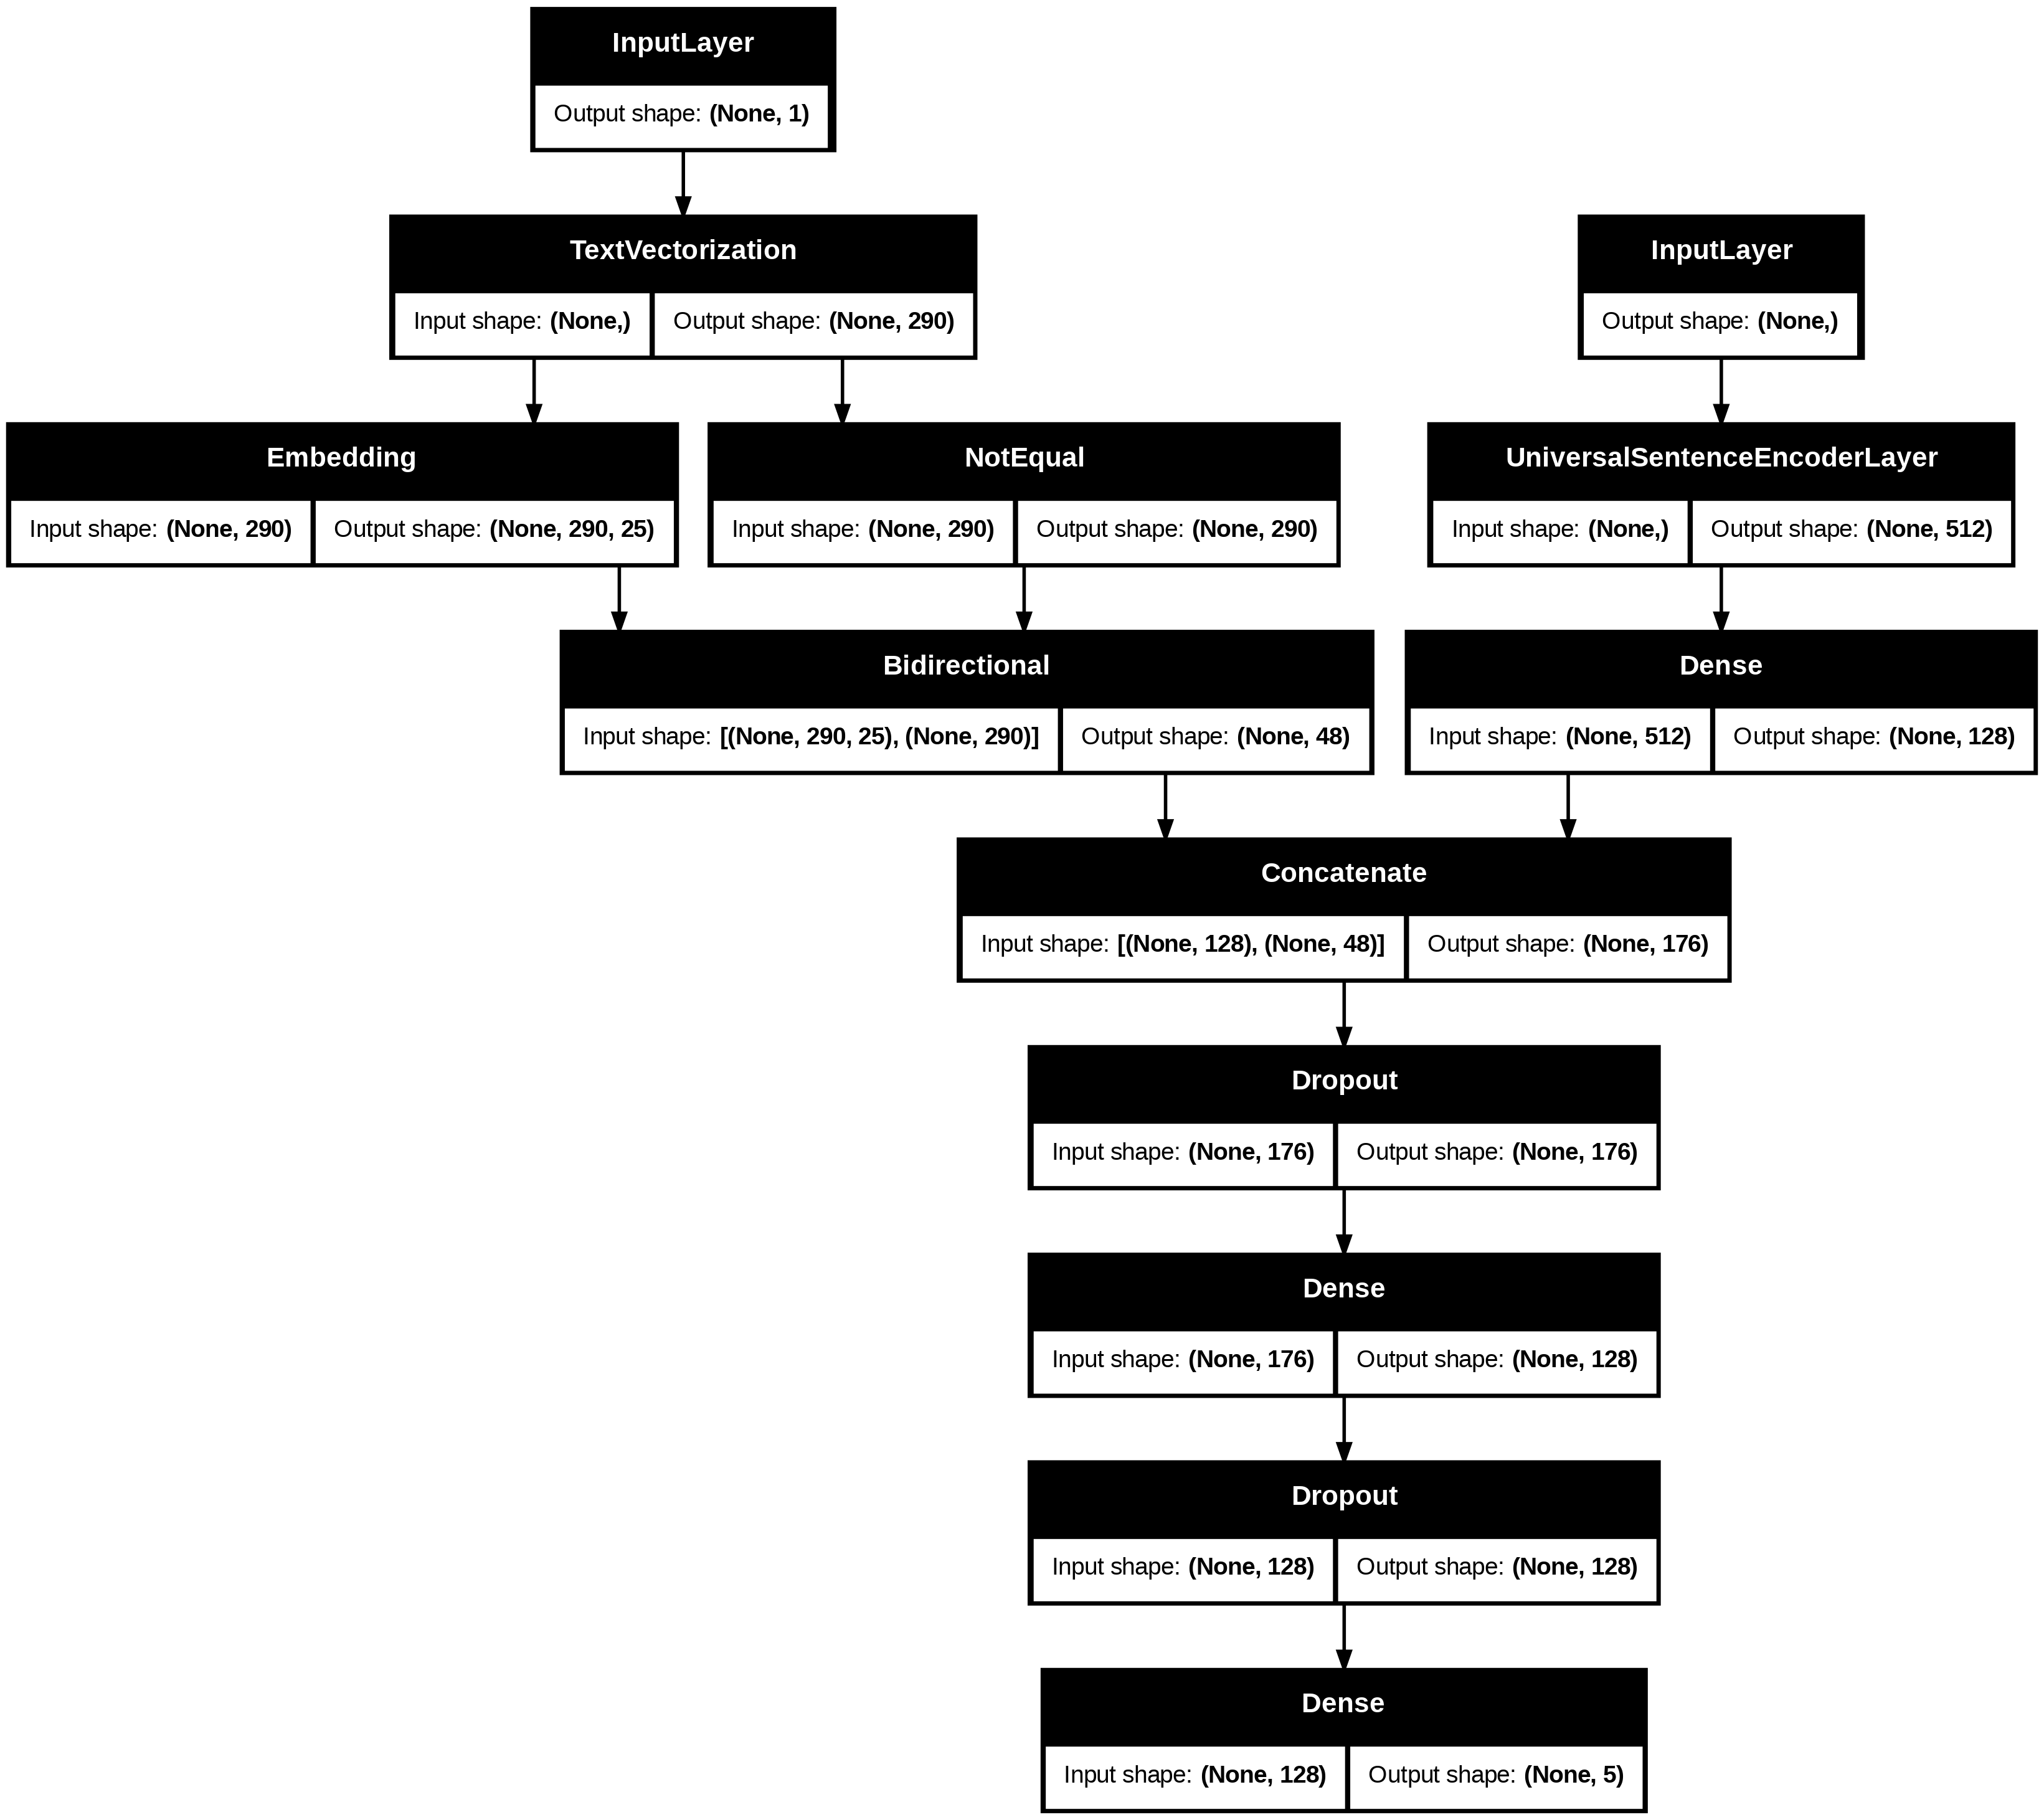

In [125]:
# Plot the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [126]:
# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and char data into tf.data Dataset


In [127]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [128]:
# Repeat with val data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [129]:
# Checkout dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit the model

In [130]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['token_input'], ['char_input']]
Received: inputs=('Tensor(shape=(None,))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


562/562 ━━━━━━━━━━━━━━━━━━━━ 202s 341ms/step - accuracy: 0.5175 - loss: 1.1671 - val_accuracy: 0.7021 - val_loss: 0.7772
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 204s 363ms/step - accuracy: 0.6866 - loss: 0.8136 - val_accuracy: 0.7301 - val_loss: 0.7204
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 259s 460ms/step - accuracy: 0.7024 - loss: 0.7821 - val_accuracy: 0.7404 - val_loss: 0.7006


In [132]:
# Evaluate on all val data
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 96s 101ms/step - accuracy: 0.7317 - loss: 0.7041


[0.7056180834770203, 0.7312657237052917]

In [134]:
# Make pred probs
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['token_input'], ['char_input']]
Received: inputs=('Tensor(shape=(32,))', 'Tensor(shape=(32,))')
  warnings.warn(msg)


944/945 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['token_input'], ['char_input']]
Received: inputs=('Tensor(shape=(None,))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


945/945 ━━━━━━━━━━━━━━━━━━━━ 72s 75ms/step


array([[4.4185609e-01, 3.9127845e-01, 4.8993179e-03, 1.5346454e-01,
        8.5015399e-03],
       [3.0634505e-01, 5.5053931e-01, 4.5580026e-03, 1.3630794e-01,
        2.2496302e-03],
       [3.0463114e-01, 1.8329801e-01, 6.0088083e-02, 3.8694903e-01,
        6.5033704e-02],
       ...,
       [5.4089265e-04, 1.2884302e-02, 3.3739254e-02, 1.7922300e-04,
        9.5265639e-01],
       [5.0528194e-03, 5.8574352e-02, 1.5468928e-01, 2.6736986e-03,
        7.7900988e-01],
       [2.8068992e-01, 3.0775565e-01, 3.4257254e-01, 1.9193308e-02,
        4.9788542e-02]], dtype=float32)

In [135]:
# Make labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [137]:
# Calculate results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.12657222295776,
 'precision': 0.7337642892238194,
 'recall': 0.7312657222295776,
 'f1': 0.7292243695803965}

## Model 5: tokens + chars + positional embeddings

In [138]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
